In [1]:
import time

import numpy as np
from numpy import genfromtxt
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from numba import jit

In [3]:
import scipy.special as ss
import scipy.signal as sig
import scipy.interpolate as interp

In [4]:
# constant diffusion
g = 0.25

# levy alpha parameter
alpha = 1.0

# time step
h = 0.01

0.015625


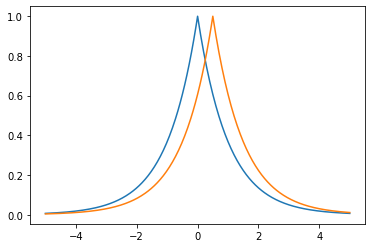

In [5]:
# for stretch = 1, this is an equispaced grid on the closed interval [-lmax, lmax]
# for stretch > 1, this is a way to create a non-equispaced grid on [-lmax, lmax]
#                  that is highly concentrated near the origin
npts = 129
stretch = 1.0
lmax = 32

du = 2.0/(npts - 1)
print(du)
startvec = -1.0 + np.arange(npts)*du
uvec = lmax*np.sign(startvec)*(np.abs(startvec)**stretch)

# this is a scaling factor used in all the collocation functions below
zeta = 1.0

# unnormalized Laplace PDF
@jit
def xi(u):
    return np.exp(-np.abs(u)/zeta)

# checking to see how much overlap we have on our grid in u space
uuvec = np.linspace(-5,5,401)
plt.plot(uuvec, xi(uuvec-uvec[(npts-1)//2 + 0]))
plt.plot(uuvec, xi(uuvec-uvec[(npts-1)//2 + 1]))
plt.show()

In [6]:
# all the matrices are defined in the notes
udiffmat = (np.expand_dims(uvec,0) - np.expand_dims(uvec,0).T)
JJ = 5
ximats = np.zeros((4*JJ+1, npts, npts))
for j in range(4*JJ+1):
    ximats[j, :, :] = xi(udiffmat + j - 2*JJ)
    
a = (1+0j)*ximats[2*JJ]
d = (1+0j)*np.diag(np.exp(-h*np.abs(uvec*g)**alpha))

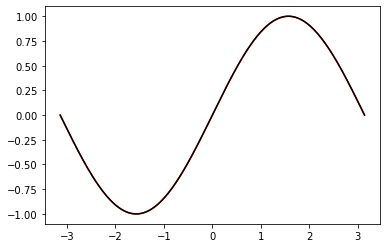

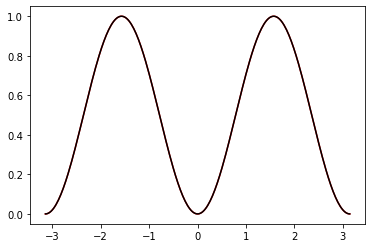

In [7]:
# set up true Fourier coefficients
truecoefs = np.zeros(2*JJ+1, dtype=np.complex128)
truecoefs[JJ+1] = -0.5j
truecoefs[JJ-1] = 0.5j

# check whether these coefficients work for f(x)
xmax = np.pi
xpts = 256
xvec = np.linspace(-xmax, xmax, xpts)
testfn = np.zeros(xpts, dtype=np.complex128)
for j in range(-JJ, JJ+1):
    testfn += truecoefs[j+JJ]*np.exp(1j*j*xvec)

plt.plot(xvec, np.real(testfn), color='red')
plt.plot(xvec, np.sin(xvec), color='black')
plt.show()

# check whether these coefficients work for f^2(x)
# note convolution below
testfn = np.zeros(xpts, dtype=np.complex128)
for k in range(-2*JJ, 2*JJ+1):
    thiscoef = 0
    for j in range(-JJ, JJ+1):
        if np.abs(k-j) <= JJ:
            thiscoef += truecoefs[j+JJ]*truecoefs[k-j+JJ]
    testfn += thiscoef*np.exp(1j*k*xvec)

plt.plot(xvec, np.real(testfn), color='red')
plt.plot(xvec, np.sin(xvec)**2, color='black')
plt.show()

In [8]:
# by hand version of scipy.signal.convolve
# convcoefs = np.zeros(4*JJ+1, dtype=np.complex128)
# for k in range(-2*JJ, 2*JJ+1):
#     for j in range(-JJ, JJ+1):
#         if np.abs(k-j) <= JJ:
#             convcoefs[k+2*JJ] += truecoefs[j+JJ]*truecoefs[k-j+JJ]

start = time.time()

b = 1j*h*np.einsum('i,ijk->jk',truecoefs, ximats[JJ:(3*JJ+1),:,:] ) @ np.diag(uvec)
convcoefs = sig.convolve(truecoefs, truecoefs)
b += -0.5*h**2*np.einsum('i,ijk->jk',convcoefs, ximats) @ np.diag(uvec**2)

end = time.time()
print(end - start)

0.005999088287353516


In [9]:
# SLOW VERSION
# this b is actually b - a
# start = time.time()

# b = np.zeros((npts, npts), dtype=np.complex128)
# for j in range(-JJ, JJ+1):
#     b += 1j*truecoefs[j+JJ]*h*ximats[j+2*JJ,:,:] @ np.diag(uvec)
# for k in range(-2*JJ, 2*JJ+1):
#     thiscoef = 0
#     for j in range(-JJ, JJ+1):
#         if np.abs(k-j) <= JJ:
#             thiscoef += truecoefs[j+JJ]*truecoefs[k-j+JJ]
#     b += -0.5*h**2*thiscoef*ximats[k+2*JJ,:,:] @ np.diag(uvec**2)

# end = time.time()
# print(end - start)

# np.sum(np.abs(bnew - b))

In [10]:
propagator = np.linalg.inv(a - d @ b.T) @ d @ a

# check stability of propagator
np.max(np.abs(np.linalg.eig(propagator)[0]))

# # no splitting -- warning, probably unstable
# # propagator = np.linalg.inv(a) @ d @ (a + b)

1.0000000000000027

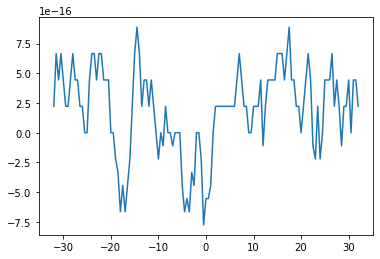

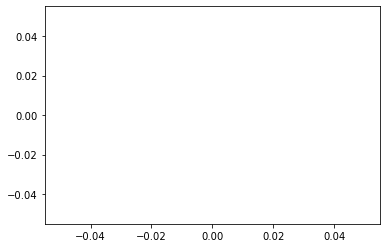

In [11]:
# set up initial condition, a mean-zero Gaussian (characteristic function)
# initvar = 0.05
# psi0 = np.exp(-(initvar**2/2)*uvec**2)
psi0 = np.ones(uvec.shape)
# psi0 = np.exp(1j*0.5*uvec)

# represent initial condition using collocation functions
gamma = np.linalg.inv(a) @ psi0

# check to see how well we can reconstruct the initial condition 
plt.plot(np.real(uvec), np.real(a @ gamma - psi0))
plt.show()
plt.plot(np.imag(uvec), np.imag(a @ gamma - psi0))
plt.show()



In [12]:
# set up time stepping
# store all the characteristic functions
numsteps = 401

gammamat = np.zeros((npts, numsteps+1), dtype=np.complex128)
gammamat[:, 0] = gamma

for iii in range(numsteps):
    gammamat[:, iii+1] = propagator @ gammamat[:, iii]
    normalization = a[(npts-1)//2, :] @ gammamat[:, iii+1]
    print(normalization)
    
    # forcefully renormalized at every time step
    # we'd like to avoid doing this, as this is a total hack:
    # gammamat[:, iii+1] /= normalization
    # print( a[(npts-1)//2, :] @ gammamat[:, iii+1] )


(1.0000000000000004+0j)
(1+0j)
(1.0000000000000002+0j)
(1+0j)
(1+0j)
(1.0000000000000009+0j)
(1.0000000000000007+0j)
(1.000000000000001+0j)
(1.000000000000001+0j)
(1.000000000000001+0j)
(1.000000000000002+0j)
(1.000000000000002+0j)
(1.0000000000000024+0j)
(1.0000000000000029+0j)
(1.0000000000000029+0j)
(1.000000000000003+0j)
(1.0000000000000029+0j)
(1.000000000000003+0j)
(1.000000000000003+0j)
(1.000000000000003+0j)
(1.0000000000000036+0j)
(1.0000000000000038+0j)
(1.0000000000000036+0j)
(1.000000000000004+0j)
(1.0000000000000042+0j)
(1.0000000000000044+0j)
(1.0000000000000042+0j)
(1.000000000000004+0j)
(1.0000000000000042+0j)
(1.0000000000000044+0j)
(1.0000000000000047+0j)
(1.0000000000000049+0j)
(1.0000000000000049+0j)
(1.0000000000000047+0j)
(1.000000000000005+0j)
(1.0000000000000049+0j)
(1.0000000000000058+0j)
(1.0000000000000053+0j)
(1.0000000000000058+0j)
(1.0000000000000062+0j)
(1.0000000000000058+0j)
(1.0000000000000058+0j)
(1.0000000000000062+0j)
(1.0000000000000067+0j)
(1.0000

In [27]:
xmax = 40
xpts = 4096
xvec = np.linspace(-xmax, xmax, xpts)
ftmat = np.exp(-1j * np.expand_dims(uvec,1) @ np.expand_dims(xvec, 0))

# going backwards from the characteristic function to the Cauchy PDF,
# with scaling factor zeta included:
base = zeta/(np.pi*(1.0 + zeta**2*xvec**2))

# reconstruct PDF from final characteristic function
mypdf = np.real(gammamat[:, numsteps] @ ftmat) * base

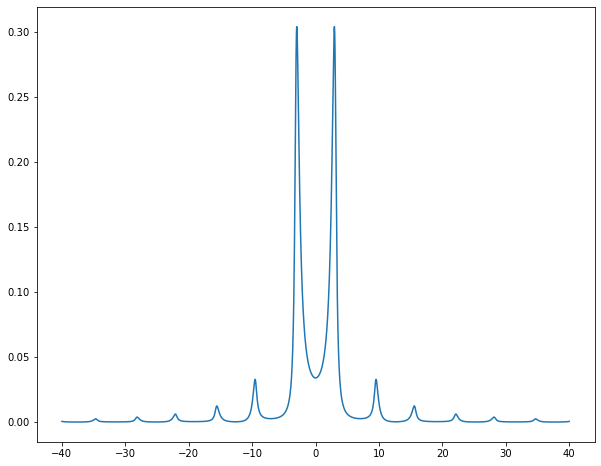

In [28]:
plt.figure(figsize=(10,8))
plt.plot(xvec, mypdf)
plt.show()

In [29]:
np.trapz(mypdf,xvec)

0.9709809807699118